In [153]:
from datetime import datetime
import os
import requests
import bz2
import xarray as xr

def get_run():
    now = datetime.now()
    date_string = now.strftime('%Y%m%d')
    utc_now = datetime.utcnow()
    
    if (utc_now.replace(hour=4, minute=0, second=0, microsecond=0) 
        <= utc_now < utc_now.replace(hour=9, minute=0, second=0, microsecond=0)):
        run="00"
    elif (utc_now.replace(hour=9, minute=0, second=0, microsecond=0) 
        <= utc_now < utc_now.replace(hour=16, minute=0, second=0, microsecond=0)):
        run="06"
    elif (utc_now.replace(hour=16, minute=0, second=0, microsecond=0) 
        <= utc_now < utc_now.replace(hour=21, minute=0, second=0, microsecond=0)):
        run="12"
    elif (utc_now.replace(hour=21, minute=0, second=0, microsecond=0) 
        <= utc_now):
        run="18"
    
    return now.strftime('%Y%m%d')+run, run

var_2d_list = ['alb_rad','alhfl_s','ashfl_s','asob_s','asob_t','aswdifd_s','aswdifu_s',
          'aswdir_s','athb_s','cape_con','cape_ml','clch','clcl','clcm','clct',
          'clct_mod','cldepth','h_snow','hbas_con','htop_con','htop_dc','hzerocl',
          'pmsl','ps','qv_2m','qv_s','rain_con','rain_gsp','relhum_2m','rho_snow',
          'runoff_g','runoff_s','snow_con','snow_gsp','snowlmt','synmsg_bt_cl_ir10.8',
          't_2m','t_g','t_snow','tch','tcm','td_2m','tmax_2m','tmin_2m','tot_prec',
          'u_10m','v_10m','vmax_10m','w_snow','w_so','ww','z0']

var_3d_list = ['clc','fi','omega','p','qv','relhum','t','tke','u','v','w']

def find_file_name(vars_2d=None,
                   vars_3d=None,
                   f_time=0, 
                   base_url = "https://opendata.dwd.de/weather/nwp",
                   model_url = "icon-eu/grib"):
    '''Find file names to be downloaded given input variables and
    a forecast lead time f_time (in hours).
    - vars_2d, a list of 2d variables to download, e.g. ['t_2m']
    - vars_3d, a list of 3d variables to download with pressure
      level, e.g. ['t@850','fi@500']
      '''
    date_string, run_string = get_run()
    urls = []
    if vars_2d is not None:
        if type(vars_2d) is not list:
            vars_2d = [vars_2d]
        for var in vars_2d:
            var_url="icon-eu_europe_regular-lat-lon_single-level"
            urls.append("%s/%s/%s/%s/%s_%s_%03d_%s.grib2.bz2" % 
                        (base_url, model_url, run_string, var,
                          var_url, date_string, f_time, var.upper()) )
    if vars_3d is not None:
        if type(vars_3d) is not list:
            vars_3d = [vars_3d]
        for var in vars_3d:
            var_t, plev = var.split('@')
            var_url="icon-eu_europe_regular-lat-lon_pressure-level"
            urls.append("%s/%s/%s/%s/%s_%s_%03d_%s_%s.grib2.bz2" % 
                        (base_url, model_url, run_string, var_t,
                          var_url, date_string, f_time, plev, var_t.upper()) )
    
    return urls

def download_extract_files(urls, folder='/tmp/'):
    '''Given a list of urls download and bunzip2 them.
    Return a list of the path of the extracted files'''
    extracted_files = []
    if type(urls) is list:
        urls_list = urls
    else:
        urls_list = [urls]
    for url in urls_list:
        filename = folder+os.path.basename(url).replace('.bz2','')
        if os.path.exists(filename):
            extracted_files.append(filename)
            continue
        else:
            r = requests.get(url, stream=True)
            if r.status_code == requests.codes.ok:
                with r.raw as source, open(filename, 'wb') as dest:
                    dest.write(bz2.decompress(source.read()))
                extracted_files.append(filename)
            else:
                r.raise_for_status()
    
    return extracted_files

def get_dset(vars_2d=None, vars_3d=None, f_time=0):
    if vars_2d is not None or vars_3d is not None:
        urls = find_file_name(vars_2d=vars_2d,
                              vars_3d=vars_3d,
                              f_time=f_time)
        fils = download_extract_files(urls)
        ds = xr.open_mfdataset(fils, engine='cfgrib',
                               compat='override')
        
    return ds

CPU times: user 460 ms, sys: 16 ms, total: 476 ms
Wall time: 476 ms


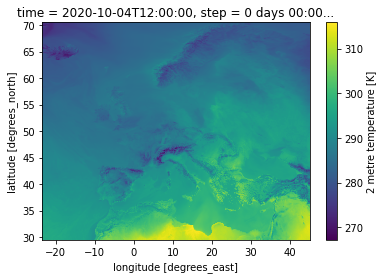

In [162]:
%%time
ds = get_dset(vars_2d='t_2m', vars_3d=['t@850','fi@500'])
ds.t2m.plot()